# Trying Variations 4.0

## 4. Adding Batch Norm and 1x1 filter

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [3]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import datetime
import os
import torchvision
import time
import copy
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [4]:
torch.__version__

'1.7.1+cu110'

In [5]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

##### Creating a function for getting training data CIFAR100

In [6]:
def give_me_train_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a train dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    # defining the transformations on the train data
    
    transformations = [transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.RandomRotation(15),
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]
    transform_train = transforms.Compose(transformations)
    
    train_set = CIFAR100('./data/cifar100', train=True, 
                         download=True, transform=transform_train)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs,
                                               shuffle=True, num_workers=num_workers)
    return train_loader

def give_me_test_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a test dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    
    # defining transformations on the test data
    
    transformations = [transforms.ToTensor(), transforms.Normalize(mean, std)]
    transform_test = transforms.Compose(transformations)
    
    valid_set = CIFAR100('./data/cifar100', train=False,
                  download=True, transform=transform_test)
    val_loader = torch.utils.data.DataLoader(valid_set, batch_size=bs, shuffle=False, 
                                             num_workers=num_workers)
    return val_loader

### Creating the model architecture

#### Following Changes have been made to the orignal archtecture

1. Added a convolutional of channel size = 32 at the beginning of the network with kernel size of 1, stride of 1, and padding of 0

2. Added Batch Norm before every ReLU activation

3. Removed Maxpooling layer (to further add residual connections)

4. Added a Adaptive Average Pooling at the very end

Arch from Variation 2, Trial 2 (model with layers 11, 22, 33 performed better on 10 epochs; hence considering it for this variation)

In [12]:
def _conv_block(in_f, out_f, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs), 
        nn.BatchNorm2d(out_f), 
        nn.ReLU())

class SimpleResNet(nn.Module):
    def __init__(self, in_c, n_classes):
        super(SimpleResNet, self).__init__()
        # creating conv blocks with 1 Conv layer, 1 Batch Norm, ReLU
        kz = 5
        st = 1
        padd = 2
        self.conv_basic = _conv_block(in_c, 32, kernel_size = 1, stride = 1, padding = 0)
        
        self.conv_block11 = _conv_block(32, 64, kernel_size = kz, stride = st, padding = padd)
        self.conv_block12 = _conv_block(64, 64, kernel_size = kz, stride = st, padding = padd)
        
        self.conv_block21 = _conv_block(64, 128, kernel_size = kz, stride = st, padding = padd)
        self.conv_block22 = _conv_block(128, 128, kernel_size = kz, stride = st, padding = padd)

        self.conv_block31 = _conv_block(128, 256, kernel_size = kz, stride = st, padding = padd)
        self.conv_block32 = _conv_block(256, 256, kernel_size = kz, stride = st, padding = padd)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2,2))
        self.dense_decoder = nn.Sequential(
            nn.Linear(1024, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1024), 
            nn.ReLU(),
            nn.Linear(1024, n_classes))

        
    def forward(self, x):
        x = self.conv_basic(x)
        x = self.conv_block11(x)
        x = self.conv_block12(x)
        
        x = self.conv_block21(x)
        x = self.conv_block22(x)
        
        x = self.conv_block31(x)
        x = self.conv_block32(x)

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dense_decoder(x)
        
        return x

##### Sending the model to gpu and printing the summary of the model architecture

In [13]:
device = 'cuda'
model = SimpleResNet(3, 100)
model.to(device) # sending our model to gpu.

# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             128
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          51,264
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]         102,464
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]         204,928
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]         409,728
      BatchNorm2d-14          [-1, 128,

##### Preparing our data loaders for training and test.
Batch size is 128 (tried 256 and 512, 128 gives better performance)

In [14]:
train_loader = give_me_train_data(bs = 128, num_workers=4, shuffle=True)
val_loader = give_me_test_data(bs = 128, num_workers=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [16]:
# Initialize the weights of layers.
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
model.apply(init_weights)

SimpleResNet(
  (conv_basic): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block11): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block12): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block22): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, mom

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history, val_loss_history = [], []
    train_acc_history, train_loss_history = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_train = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        loss_train += loss.item()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                
        # decreasing learning rate with the epochs
        scheduler.step(loss_train)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [18]:
# validate the training on validation set
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        print(name)
        print(loader)
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                y = model(imgs)
                _, predicted = torch.max(y, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.4f}".format(name, correct/total))
        print("{}: correct, total = {},{}".format(name, correct, total))

### Trial 1
1. Added a convolutional of channel size = 32 at the beginning of the network with kernel size of 1, stride of 2, and padding of 0

2. Added Batch Norm before every ReLU activation

3. Removed Maxpooling layer (to further add residual connections)

4. Added a Adaptive Average Pooling at the very end

In [19]:
# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             128
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          51,264
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]         102,464
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]         204,928
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]         409,728
      BatchNorm2d-14          [-1, 128,

In [20]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 3.7934 Acc: 0.1165
val Loss: 3.4316 Acc: 0.1715

Epoch 2/10
----------
train Loss: 3.1923 Acc: 0.2184
val Loss: 3.0636 Acc: 0.2525

Epoch 3/10
----------
train Loss: 2.8425 Acc: 0.2835
val Loss: 2.6642 Acc: 0.3196

Epoch 4/10
----------
train Loss: 2.5819 Acc: 0.3350
val Loss: 2.4163 Acc: 0.3758

Epoch 5/10
----------
train Loss: 2.3749 Acc: 0.3799
val Loss: 2.3087 Acc: 0.4031

Epoch 6/10
----------
train Loss: 2.2032 Acc: 0.4143
val Loss: 2.1649 Acc: 0.4277

Epoch 7/10
----------
train Loss: 2.0628 Acc: 0.4471
val Loss: 2.1114 Acc: 0.4458

Epoch 8/10
----------
train Loss: 1.9346 Acc: 0.4777
val Loss: 1.9486 Acc: 0.4812

Epoch 9/10
----------
train Loss: 1.8368 Acc: 0.4989
val Loss: 1.9840 Acc: 0.4837

Epoch 10/10
----------
train Loss: 1.7483 Acc: 0.5171
val Loss: 1.8428 Acc: 0.5109

Training complete in 9m 35s
Best val Acc: 0.510900


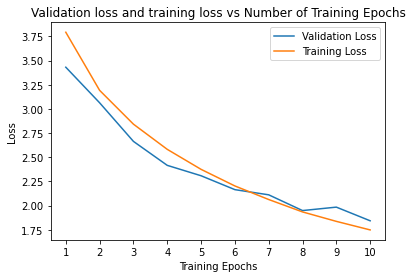

In [21]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [22]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.5247
train: correct, total = 26233,50000
val
Accuracy val: 0.5109
val: correct, total = 5109,10000
